In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from matplotlib import colormaps
from scipy.integrate import solve_ivp

# Animation/Data Generation

In [2]:
animation.writer = animation.writers['ffmpeg']

In [7]:
# Parameters
g = 9.81  # acceleration due to gravity (m/s^2)
L1 = 1.0  # length of the first rod (m)
L2 = 1.0  # length of the second rod (m)
m1 = 1.0  # mass of the first bob (kg)
m2 = 1.0  # mass of the second bob (kg)
t_final = 20
exp_name = 'start_diagonal'

# Initial conditions
theta1_init = 2*np.pi/3    # Note: theta=pi/2 points right and theta=0 points down
theta2_init = 5*np.pi/6    # Angle relative to (0,0) NOT the mid point
z1_init = 0.0            # initial angular velocity of the first pendulum (rad/s)
z2_init = 0.0            # initial angular velocity of the second pendulum (rad/s)

# Equations of motion
def derivatives(t, state):
    theta1, z1, theta2, z2 = state
    delta = theta2 - theta1

    denominator1 = (m1 + m2) * L1 - m2 * L1 * np.cos(delta) ** 2
    denominator2 = (L2 / L1) * denominator1

    dtheta1_dt = z1
    dz1_dt = (
        (m2 * L1 * z1 ** 2 * np.sin(delta) * np.cos(delta)
         + m2 * g * np.sin(theta2) * np.cos(delta)
         + m2 * L2 * z2 ** 2 * np.sin(delta)
         - (m1 + m2) * g * np.sin(theta1))
        / denominator1
    )
    dtheta2_dt = z2
    dz2_dt = (
        (-m2 * L2 * z2 ** 2 * np.sin(delta) * np.cos(delta)
         + (m1 + m2) * g * np.sin(theta1) * np.cos(delta)
         - (m1 + m2) * L1 * z1 ** 2 * np.sin(delta)
         - (m1 + m2) * g * np.sin(theta2))
        / denominator2
    )

    return np.array([dtheta1_dt, dz1_dt, dtheta2_dt, dz2_dt])

## Animation Generator
This animation includes the double pendulum with a tail attempting to follow the given trajectory of the ground_truth.

Needs to be adapted for predicted results from the model.

In [ ]:
state_0 = np.array([theta1_init, z1_init, theta2_init, z2_init])
t = np.linspace(0, t_final, 2000)  # time array

# Solve the system
solution = solve_ivp(derivatives, (0, t_final), state_0, t_eval=t)
theta1, theta2 = solution.y[0], solution.y[2]
# print(solution.y)

# Convert to Cartesian coordinates
x1 = L1 * np.sin(theta1)
y1 = -L1 * np.cos(theta1)
x2 = x1 + L2 * np.sin(theta2)
y2 = y1 - L2 * np.cos(theta2)

# Animation
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-(L1+L2)*1.1, (L1+L2)*1.1)
ax.set_ylim(-(L1+L2)*1.1, (L1+L2)*1.1)
ax.set_aspect('equal')

cmap = colormaps['rainbow']
norm = plt.Normalize(0,1)
lag = 20
front = 30
back = 50

points1, = ax.plot(x2[0:front+1], y2[0:front+1], lw=5, label='actual')
points2, = ax.plot([], [], lw=7, color='black', label='predic')
line1, = ax.plot([], [], 'o-', lw=2, color='blue')
legend = ax.legend(loc='upper right')

def update(frame):
    global legend
    if frame - back < 0:
        points1.set_data(x2[0:frame+front+1], y2[0:frame+front+1])
        # points1.set_color(cmap(norm(np.linspace(0,len(t),len(x2[0:frame+front+1]))[0:frame+front+1])))
    elif frame + front > len(t):
        points1.set_data(x2[frame-back:len(t)], y2[frame-back:len(t)])
        # points1.set_color(cmap(norm(np.linspace(0,len(t),len(x2[frame-back:len(t)]))[frame-back:len(t)])))
    else:
        points1.set_data(x2[frame-back:frame+front+1], y2[frame-back:frame+front+1])
        # points1.set_color(cmap(norm(np.linspace(0,len(t),len(x2[frame-back:frame+front+1]))[frame-back:frame+front+1])))
    color = cmap(1 - norm(frame / len(t)))
    points1.set_color(color)

    if frame - lag < 0:
        points2.set_data(x2[0:frame+1], y2[0:frame+1])
    else:
        points2.set_data(x2[frame-lag:frame+1], y2[frame-lag:frame+1])

    line1.set_data([0, x1[frame], x2[frame]], [0, y1[frame], y2[frame]])
    legend.remove()
    legend = ax.legend(loc='upper right')
    return line1, points1, points2

ani = FuncAnimation(fig, update, frames=len(t), interval=(t_final / 2), blit=True)
ani.save(f'{exp_name}.mp4')
plt.close(fig)

## Data Generation

In [8]:
# Time span and resolution
t_start = 0.0
t_end = 5.0
num_points = 200
t_eval = np.linspace(t_start, t_end, num_points)

# Generate multiple initial conditions
# Each initial condition is: [theta1, z1, theta2, z2]
# For simplicity, vary the initial angles. We can start the pendulums at rest (z1 = z2 = 0).
# initial_conditions = [
#     [np.pi/2, 0.0, np.pi/2, 0.0],
#     [np.pi/3, 0.0, np.pi/4, 0.0],
#     [np.pi/4, 0.0, np.pi/2, 0.0]
# ]

# Number of different initial conditions you want
num_conditions = 128

initial_conditions = []
for _ in range(num_conditions):
    # Sample theta1 and theta2 from a uniform distribution [0, pi]
    theta1 = np.random.uniform(0, np.pi)
    theta2 = np.random.uniform(0, np.pi)
    z1 = 0.0
    z2 = 0.0
    ic = [theta1, z1, theta2, z2]
    initial_conditions.append(ic)

all_trajectories = []
all_initial_conditions = []

for ic in initial_conditions:
    sol = solve_ivp(derivatives, [t_start, t_end], ic, t_eval=t_eval, method='RK45')
    if sol.status == 0:  # successful integration
        # sol.y has shape (4, num_points), transpose to (num_points, 4)
        trajectory = sol.y.T
        all_trajectories.append(trajectory)
        all_initial_conditions.append(ic)
    else:
        print(f"Integration failed for initial condition: {ic}")

all_initial_conditions = np.array(all_initial_conditions)   # shape: (num_conditions, 4)
all_trajectories = np.array(all_trajectories)               # shape: (num_conditions, num_points, 4)

print("Initial Conditions Shape:", all_initial_conditions.shape)
print("Trajectories Shape:", all_trajectories.shape)

Initial Conditions Shape: (128, 4)
Trajectories Shape: (128, 200, 4)


# Neural ODE Model
Contains Metrics, Training setup, and plotting of metrics and loss.

In [4]:
!pip install torchdiffeq
# !pip uninstall sympy
# !pip install sympy

## Metrics
```time_to_divergence``` : returns a single integer of the time where it diverges.(Cannot be plotted)

```total_divergence_at_time``` : returns a single number of the divergence up to timestep ```t_idx```.(Cannot be plotted as is)

```global_error``` : returns the max error up to timestep ```t_idx```. (Cannot be plotted as is)

```one_step_error``` : returns the error of one step for all timesteps given. (Can be plotted as is)

In [24]:
def time_to_divergence(y, y_hat, lambda_=0, tol=1e-5):
    """
    Returns min {t : (||theta(t) - theta_hat(t)|| + lambda_ ||theta'(t) - theta_hat'(t)||) >= tol}

    y : True values of theta (first two columns) and theta' (last two columns)
    y_hat : predicted values of y
    t_idx : The index such that y[t_idx] = y(T)
    lambda : regularization parameter
    tol : maximum error
    """
    return np.min(np.where(one_step_error(y, y_hat, lambda_) >= tol))


def total_divergence_at_time(t_idx, y, y_hat, lambda_=0):
    """
    Returns ||theta - theta_hat|| + lambda_ ||theta' - theta_hat'||

    y : True values of theta (first two columns) and theta' (last two columns)
    y_hat : predicted values of y
    t_idx : The index such that y[t_idx] = y(T)
    lambda : regularization parameter
    """
    theta, theta_hat = y[:t_idx, :2], y_hat[:t_idx, :2]
    theta_prime, theta_prime_hat = y[:t_idx, 2:], y_hat[:t_idx, 2:]

    return (np.linalg.norm(theta - theta_hat) +
               lambda_ * np.linalg.norm(theta_prime - theta_prime_hat))


def global_error(t_idx, y, y_hat, lambda_=0):
    """
    Returns max_{t<T} (||theta(t) - theta_hat(t)|| + lambda_ ||theta'(t) - theta_hat'(t)||)
    Agrees with spherical error (3.11) when lambda_=1 and t_idx is as large as possible

    y : True values of theta (first two columns) and theta' (last two columns)
    y_hat : predicted values of y
    t_idx : The index such that y[t_idx] = y(T)
    lambda : regularization parameter
    """
    return max(one_step_error(y, y_hat, lambda_)[:t_idx])


def one_step_error(y, y_hat, lambda_=0):
    """
    Returns L(t-1) = ||theta(t) - theta_hat(t)|| + lambda_ ||theta'(t) - theta_hat'(t)||
    Agrees with (3.13) when lambda_=1.  Note the shift in index.

    y : True values of theta (first two columns) and theta' (last two columns)
    y_hat : predicted values of y
    lambda : regularization parameter
    """
    theta, theta_hat = y[:, :2], y_hat[:, :2]
    theta_prime, theta_prime_hat = y[:, 2:], y_hat[:, 2:]

    return (np.linalg.norm(theta - theta_hat, axis=1) +
            lambda_ * np.linalg.norm(theta_prime - theta_prime_hat, axis=1))

## NODE Training and Model
Each batch consists of initial conditions ```batch_ics``` of shape ```(batch_size, 4)``` and trajectories ```batch_trajs``` of shape ```(batch_size, num_timesteps, 4)```.

In [ ]:
import torch
import torch.nn as nn
from torchdiffeq import odeint

# Example Neural ODE model definition
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.num_calls = 0
        self.net = nn.Sequential(
            nn.Linear(4, 64),  # state: (theta1, w1, theta2, w2)
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 4),
        )

    def forward(self, t, y):
        # y has shape (batch_size, 4)
        self.num_calls += 1
        return self.net(y)

In [28]:
# Suppose you have a set of initial conditions and corresponding ground-truth trajectories.
# `all_initial_conditions` might be a Tensor of shape (num_conditions, 4)
# `all_trajectories` might be a Tensor of shape (num_conditions, num_timesteps, 4)
# `time_points` is a 1D Tensor of shape (num_timesteps,)

ode_func = ODEFunc().to(device='cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(ode_func.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()
losses = []

all_initial_conditions = torch.tensor(all_initial_conditions, dtype=torch.float32)  # shape (num_conditions, 4)
all_trajectories = torch.tensor(all_trajectories, dtype=torch.float32)              # shape (num_conditions, num_timesteps, 4)
time_points = torch.linspace(t_start, t_end, num_points).to(ode_func.net[0].weight.device)    # shape (num_timesteps,)

num_epochs = 2#000
batch_size = 64

for epoch in range(num_epochs):
    # Randomly sample a batch of initial conditions
    # For example, choose batch_size conditions out of num_conditions
    idx = torch.randint(high=all_initial_conditions.shape[0], size=(batch_size,))
    batch_ics = all_initial_conditions[idx]              # shape (batch_size, 4)
    batch_trajs = all_trajectories[idx]                  # shape (batch_size, num_timesteps, 4)

    # Move data to the correct device
    batch_ics = batch_ics.to(ode_func.net[0].weight.device)
    batch_trajs = batch_trajs.to(ode_func.net[0].weight.device)

    # Forward pass through the Neural ODE: solve ODE for each initial condition
    # odeint will produce shape (num_timesteps, batch_size, 4)
    pred_trajs = odeint(ode_func, batch_ics, time_points)

    # pred_trajs: shape (num_timesteps, batch_size, 4)
    # we want loss as MSE between pred_trajs and batch_trajs
    # Transpose to match shapes: (batch_size, num_timesteps, 4)
    pred_trajs = pred_trajs.transpose(0, 1)

    loss = loss_fn(pred_trajs, batch_trajs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item()}")
    losses.append(loss.item())

# After training, the Neural ODE should generalize better over a range of initial conditions

<ipython-input-28-9762da03b4fa>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_initial_conditions = torch.tensor(all_initial_conditions, dtype=torch.float32)  # shape (num_conditions, 4)
<ipython-input-28-9762da03b4fa>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_trajectories = torch.tensor(all_trajectories, dtype=torch.float32)              # shape (num_conditions, num_timesteps, 4)


Epoch 0, Loss: 14.154365539550781
Epoch 1, Loss: 13.67868423461914


In [ ]:
def generate_data(len):
    pass

class DataLoader():
    def __init__(self, min_length, max_lenth):
        self.min_length = min_length
        self.max_length = max_lenth
    def __next__(self):
        generate_data(len=np.random.randint(self.min_length, self.max_length)+1)

In [ ]:
# Set model, optimizer and loss
ode_func = ODEFunc().to(device='cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(ode_func.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()
losses = []

# Training
dl = DataLoader(15,25)
for epoch in range(200):
    # Each batch contains a series of timesteps for a single set of initial conditions
    batch = (dl.next()[4:]).to(ode_func.net[0].weight.device)
    theta0 = batch[0]

    # Predict the next step at every timestep and calculate loss
    theta_hat = [odeint(ode_func, theta0, t) for t in np.arange(0.005, 0.005*len(batch), 0.005)]
    loss = loss_fn(theta_hat, batch[1:])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(f"Epoch {epoch}, Loss: {loss.item()}")
    if epoch % 10 == 0:
        losses.append(loss.item())

## Plotting Loss and Metrics
This includes plotting metrics over time, and the loss of various iterations of the NODE Model (i.e., changing weight decay, learning rate, number of epochs, etc.)

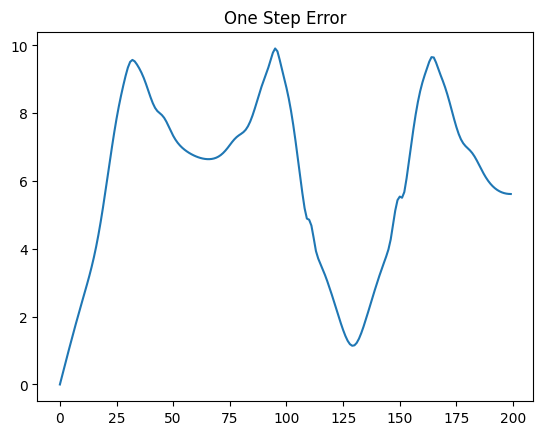

Time to Divergence: 1


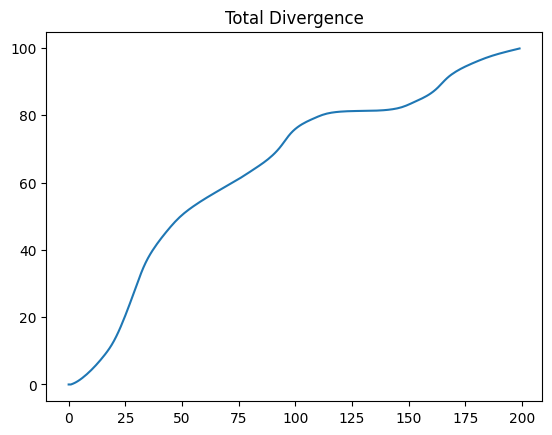

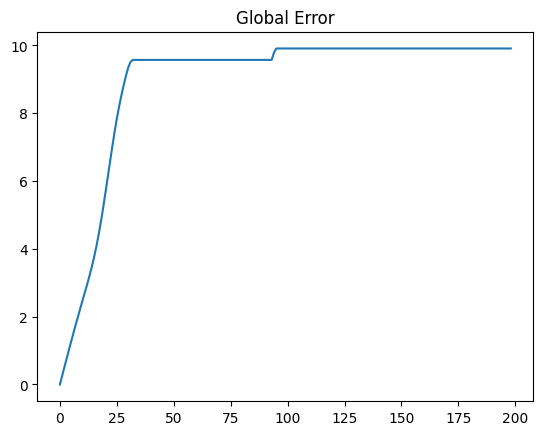

In [27]:
idx = torch.randint(high=all_initial_conditions.shape[0], size=(1,))
batch_ics = all_initial_conditions[idx]              # shape (batch_size, 4)
batch_trajs = all_trajectories[idx]                  # shape (batch_size, num_timesteps, 4)

# Move data to the correct device
batch_ics = batch_ics.to(ode_func.net[0].weight.device)
batch_trajs = batch_trajs.to(ode_func.net[0].weight.device)
pred_trajs = odeint(ode_func, batch_ics, time_points)

pred_trajs = pred_trajs.transpose(0, 1).squeeze(0)

plt.plot(one_step_error(batch_trajs.cpu().detach().numpy().squeeze(0), pred_trajs.cpu().detach().numpy(), lambda_=1))
plt.title('One Step Error')
plt.show()
print("Time to Divergence:", time_to_divergence(batch_trajs.cpu().detach().numpy().squeeze(0), pred_trajs.cpu().detach().numpy(), lambda_=1))
# plt.plot(time_to_divergence(batch_trajs.cpu().detach().numpy().squeeze(0), pred_trajs.cpu().detach().numpy(), lambda_=1))
# plt.title('Time to Divergence')
# plt.show()
plt.plot([total_divergence_at_time(idx, batch_trajs.cpu().detach().numpy().squeeze(0), pred_trajs.cpu().detach().numpy(), lambda_=1) for idx in range(time_points.shape[0])])
plt.title('Total Divergence')
plt.show()
# print(total_divergence_at_time(time_points.shape[0], batch_trajs.cpu().detach().numpy().squeeze(0), pred_trajs.cpu().detach().numpy(), lambda_=1))
plt.plot([global_error(idx, batch_trajs.cpu().detach().numpy().squeeze(0), pred_trajs.cpu().detach().numpy(), lambda_=1) for idx in range(1,time_points.shape[0])])
plt.title('Global Error')
plt.show()
# print(global_error(time_points.shape[0], batch_trajs.cpu().detach().numpy().squeeze(0), pred_trajs.cpu().detach().numpy(), lambda_=1))

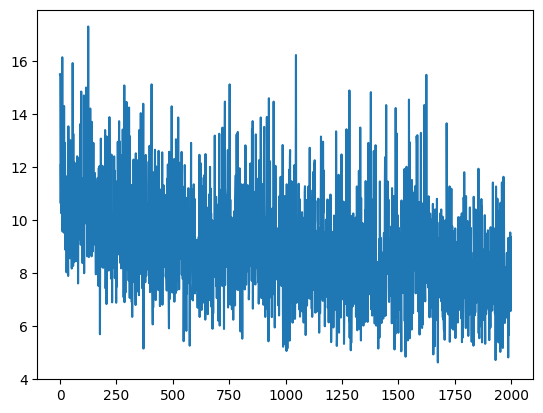

In [28]:
# With weight decay, 200 time steps, 5 second time interval, 2000 epochs -- 31 minutes
plt.plot(losses)
plt.show()

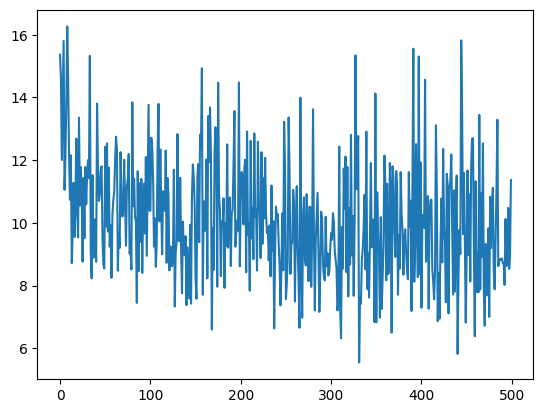

In [26]:
# With weight decay, 200 time steps, 5 second time interval -- 7 minutes
plt.plot(losses)
plt.show()

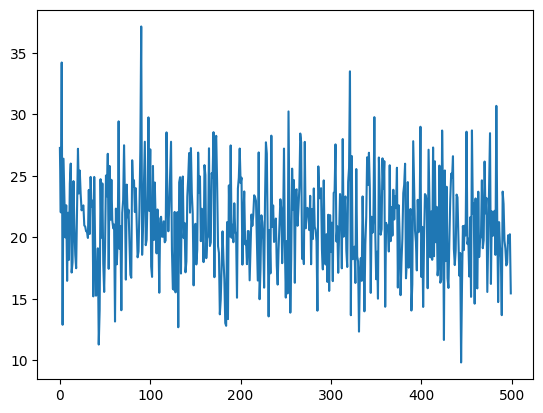

In [23]:
# With weight decay, 400 time steps, 10 second time interval -- 7 minutes
plt.plot(losses)
plt.show()

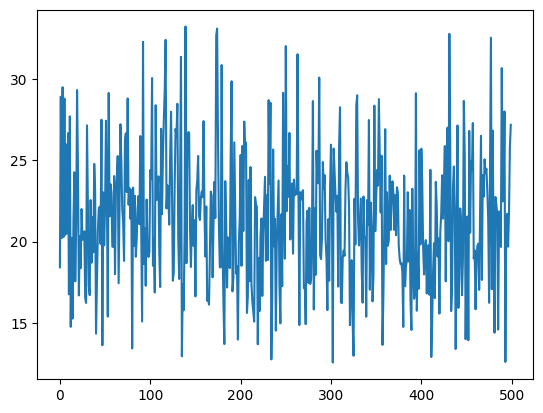

In [21]:
# 400 time steps, 10 second time interval -- 7 minutes
plt.plot(losses)
plt.show()

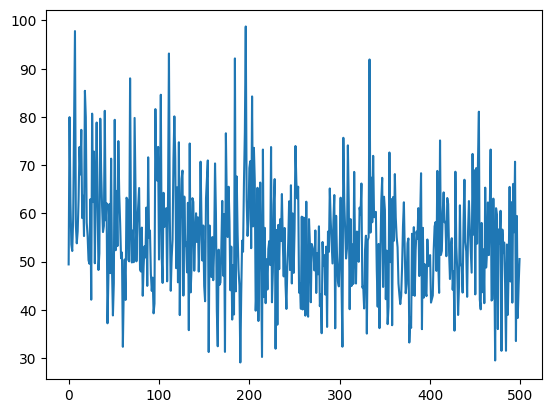

In [18]:
# With weight decay, 1000 time steps, 20 second time interval -- 11.5 minutes
plt.plot(losses)
plt.show()

# Plot Double Pendulum on top of Actual Trajectory

[]

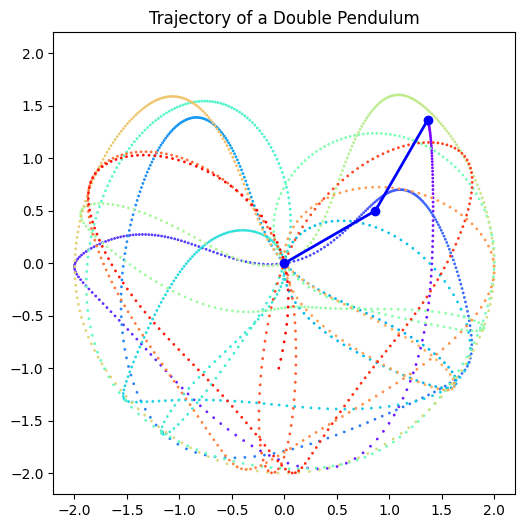

In [7]:
# Parameters
g = 9.81  # acceleration due to gravity (m/s^2)
L1 = 1.0  # length of the first rod (m)
L2 = 1.0  # length of the second rod (m)
m1 = 1.0  # mass of the first bob (kg)
m2 = 1.0  # mass of the second bob (kg)
t_final = 20
exp_name = 'start_vertical'

# Initial conditions
theta1_init = 2*np.pi/3
theta2_init = 5*np.pi/6
z1_init = 0.0            # initial angular velocity of the first pendulum (rad/s)
z2_init = 0.0            # initial angular velocity of the second pendulum (rad/s)

# Equations of motion
def derivatives(t, state):
    theta1, z1, theta2, z2 = state
    delta = theta2 - theta1

    denominator1 = (m1 + m2) * L1 - m2 * L1 * np.cos(delta) ** 2
    denominator2 = (L2 / L1) * denominator1

    dtheta1_dt = z1
    dz1_dt = (
        (m2 * L1 * z1 ** 2 * np.sin(delta) * np.cos(delta)
         + m2 * g * np.sin(theta2) * np.cos(delta)
         + m2 * L2 * z2 ** 2 * np.sin(delta)
         - (m1 + m2) * g * np.sin(theta1))
        / denominator1
    )
    dtheta2_dt = z2
    dz2_dt = (
        (-m2 * L2 * z2 ** 2 * np.sin(delta) * np.cos(delta)
         + (m1 + m2) * g * np.sin(theta1) * np.cos(delta)
         - (m1 + m2) * L1 * z1 ** 2 * np.sin(delta)
         - (m1 + m2) * g * np.sin(theta2))
        / denominator2
    )

    return np.array([dtheta1_dt, dz1_dt, dtheta2_dt, dz2_dt])


state_0 = np.array([theta1_init, z1_init, theta2_init, z2_init])
t = np.linspace(0, t_final, 2000)  # time array

# Solve the system
solution = solve_ivp(derivatives, (0, t_final), state_0, t_eval=t)
theta1, theta2 = solution.y[0], solution.y[2]
# print(solution.y)

# Convert to Cartesian coordinates
x1 = L1 * np.sin(theta1)
y1 = -L1 * np.cos(theta1)
x2 = x1 + L2 * np.sin(theta2)
y2 = y1 - L2 * np.cos(theta2)

# Animation
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-(L1+L2)*1.1, (L1+L2)*1.1)
ax.set_ylim(-(L1+L2)*1.1, (L1+L2)*1.1)
ax.set_aspect('equal')
ax.scatter(x2, y2, s=1, c=np.linspace(0,1,len(t)), cmap='rainbow')
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], 'o-', lw=2, color='blue')
plt.title('Trajectory of a Double Pendulum')
plt.show()